In [274]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from IPython.html.widgets import interact, interactive, fixed

In [275]:
gamma = 6.67384e-11

First, I defined two functions that would determine my initial velocities of both my star, $m$, and my disrupting galaxy, $S$.

The star's initial velocity is determined by the equation for the velocity pertaining to a circular obrit:
\begin{equation*}
v = \sqrt{\frac{GM}{r}}
\end{equation*}
where $G$ is the gravitational constant, $M$ is the mass of the object orbited around, and $r$ is the distance from $m$ to $M$.

In [276]:
def velocities_m(M,x,y):
    """Computes the velocities in the x and y direction of a star, m
    
    Parameters
    -------------
    M : central mass of main galaxy
    x : position of star in x-direction
    y : position of star in y-direction
    
    Returns
    ------------
    vx : velocity of star in x-direction
    vy : velocity of star in y-direction
    
    """
    rb = np.sqrt(x**2+y**2)
    v = np.sqrt((gamma*M)/rb)
    if x != 0:
        theta = np.arctan(y/x)
    else:
        theta = (np.pi/2)
    if x < 0:
        vx = v*np.sin(theta)
        vy = -v*np.cos(theta)
    elif x > 0:
        vx = -v*np.sin(theta)
        vy = v*np.cos(theta)
    elif x == 0 and y > 0:
        vx = -v*np.sin(theta)
        vy = 0
    elif x == 0 and y < 0:
        vx = v*np.sin(theta)
        vy = 0
    return vx,vy

The disrupting galaxy's initial velocity is determined by the equation pertaining to a parabolic orbit:
\begin{equation*}
v = \sqrt{\frac{2\mu}{r}}
\end{equation*}
where $\mu$ is the standard graitational parameter, $GM+GS$, and $r$ is the distance between the galaxies.

In [277]:
def velocities_S(M,S,x,y):
    """Computes the velocities in the x and y direction of a disrupting galaxy, S
    
    Parameters
    -------------
    M : central mass of main galaxy
    S : central mass of disrupting galaxy
    x : position of S in x-direction
    y : position of S in y-direction
    
    Returns
    ------------
    vx : velocity of S in x-direction
    vy : velocity of S in y-direction
    
    """
    Rb = np.sqrt(x**2+y**2)
    v = np.sqrt((2*gamma*(M+S))/(Rb))
    if x != 0:
        theta = np.arctan(y/x)
    else:
        theta = (np.pi/2)
    vx = v*np.sin(theta)
    vy = -v*np.cos(theta)
    return vx,vy

Next, I started to solve the two differential equations given:

$$ \ddot{\mathbf{r}} = -\gamma \left\{ \frac{M}{r^3}\mathbf{r} -\frac{S}{\rho^3}\boldsymbol{\rho} + \frac{S}{R^3}\boldsymbol\Re \right\} $$

$$ \ddot{\boldsymbol\Re} = -\gamma \frac{M+S}{R^3}\boldsymbol\Re$$

* $\gamma$ is the Gravitational constant.
* $M$ is the central mass of the main galaxy and $S$ is the central mass of the disrupting galaxy
* $\mathbf{r}$ is the radius vector from mass $M$ to massless point particle $m$, representing a single (massless) star in the outer disk of the main galaxy.
* $\boldsymbol\Re$ is the radius vector from $M$ to $S$
* $\boldsymbol{\rho} = \boldsymbol{\Re} - \boldsymbol{r}$

To solve these, I first defined a derivative function:

In [278]:
def derivs(solarray, t, M, S):
    """Computes the derivatives of the equations dictating the behavior of the stars orbiting galaxy M and the
    disrupting galaxy, S
    
    Parameters
    --------------
    solarray : solution array for the differential equations
    t : array of time values
    M : central mass of main galaxy
    S : central mass of disrupting galaxy
    
    Returns
    --------------
    derivarray : an array of the velocities and accelerations of galaxy S and stars, m
    
    """
    
    derivarray = np.zeros(len(solarray))
    
    Rb = np.array([solarray[0],solarray[1]])
    R = np.linalg.norm(Rb)
    vR = np.array([solarray[2],solarray[3]])
    dR = vR
    dvR = ((-gamma*(M+S)*Rb)/R**3)
    
    derivarray[0] = dR[0]
    derivarray[1] = dR[1]
    derivarray[2] = dvR[0]
    derivarray[3] = dvR[1]
    
    for n in range(1,int(len(solarray)/4)):
        rb = np.array([solarray[4*n],solarray[4*n+1]])
        r = np.linalg.norm(rb)
        vr = np.array([solarray[4*n+2],solarray[4*n+3]])
        pb = Rb - rb
        p = np.linalg.norm(pb)
        dr = vr
        dvr = -gamma*((M/r**3)*rb-(S/p**3)*pb+(S/R**3)*R)
        derivarray[4*n] = dr[0]
        derivarray[4*n+1] = dr[1]
        derivarray[4*n+2] = dvr[0]
        derivarray[4*n+3] = dvr[1]
    
    
    return derivarray
    

Then I used odeint to solve the equations

In [279]:
def equationsolver(ic,max_time,time_step,M,S):
    """Solves the differential equations using odeint and the derivs function defined above
    
    Parameters
    -------------
    ic : initial conditions
    max_time : maximum time to be used for time array
    time_step : step size of time array
    M : central mass of main galaxy
    S : central mass of disrupting galaxy
    
    Returns
    ------------
    sol : solution array for the differential equations
    """
    t = np.linspace(0,max_time,time_step)
    sol = odeint(derivs, ic, t, args=(M,S),atol=1e-5,rtol=1e-5)
    return sol

I also define a plotting function to use with the interact function to visualize the behavior of the stars when the disrupting galaxy orbits close to the main galaxy

In [344]:
def plotter(ic,max_time,time_step,M,S,n):
    """Plots the positions of the stars and disrupting galaxy at each t in the time array
    
    Parameters
    --------------
    ic : initial conditions
    max_time : maximum time to be used for time array
    time_step : step size of time array
    M : central mass of main galaxy
    S : central mass of disrupting galaxy
    n : integer
    
    Returns
    -------------
    """
    plt.figure(figsize=(15,10))
    plt.scatter(0,0,color='y',label='Galaxy M')
    plt.scatter(equationsolver(ic,max_time,time_step,M,S)[n][0],
                equationsolver(ic,max_time,time_step,M,S)[n][1],color='b',label='Galaxy S')
    for i in range(1,int(len(ic)/4)):
        a = plt.scatter(equationsolver(ic,max_time,time_step,M,S)[n][4*i],
                    equationsolver(ic,max_time,time_step,M,S)[n][4*i+1],color='r')
    a.set_label('Star')
    plt.legend()
    plt.ylim(-10,10)
    plt.xlim(-10,10)

Next, I defined some test values for a simple two star system to check if everything was working correctly

In [359]:
max_time_test = 215
time_step_test = 1050
M_test = 1e8
S_test = 1e8
S_x_test = 3
S_y_test = 3
m_x_test_1 = -1
m_y_test_1 = 1
m_x_test_2 = -1
m_y_test_2 = -1

In [360]:
vxS_test = velocities_S(M_test,S_test,S_x_test,S_y_test)[0]
vyS_test = velocities_S(M_test,S_test,S_x_test,S_y_test)[1]
vxm_test_1 = velocities_m(M_test,m_x_test_1,m_y_test_1)[0]
vym_test_1 = velocities_m(M_test,m_x_test_1,m_y_test_1)[1]
vxm_test_2 = velocities_m(M_test,m_x_test_2,m_y_test_2)[0]
vym_test_2 = velocities_m(M_test,m_x_test_2,m_y_test_2)[1]

In [361]:
ic_test = np.array([S_x_test,S_y_test,vxS_test,vyS_test,m_x_test_1,m_y_test_1,vxm_test_1,vym_test_1,
                    m_x_test_2,m_y_test_2,vxm_test_2,vym_test_2])

In [362]:
sol_test = equationsolver(ic_test,max_time_test,time_step_test,M_test,S_test)

I used interact on my plotter function to plot the positions of the stars and galaxies in my system at every time value

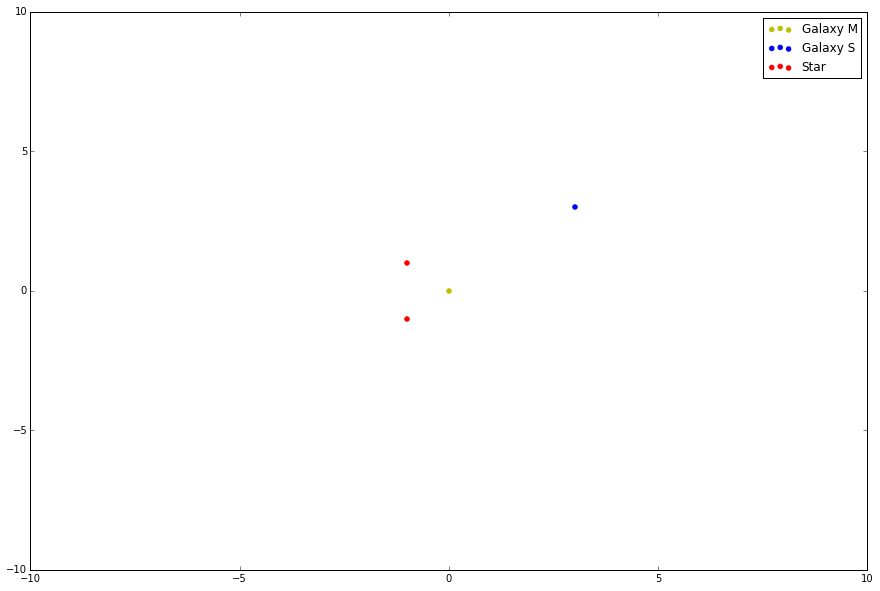

In [363]:
interact(plotter,ic=fixed(ic_test),max_time=fixed(max_time_test),time_step=fixed(time_step_test),
        M=fixed(M_test),S=fixed(S_test),n=(0,len(np.linspace(0,max_time_test,time_step_test))-1,1));

Next, I defined a function that computes the total energy of the system.  This is useful to check the error tolerances of my equationsolver function so that the total energy of the system is constant.

In [ ]:
def totalenergy(sol,M,S,max_time,time_step):
    total_energy = 0
    t = np.linspace(0,max_time_time_step)
    for n in range(0,len(t)):
        r = np.linalg.norm(np.array([sol[n][0],sol[n][1]]))
        v_S = np.linalg.norm(np.array([sol[n][2],sol[n][3]]))
        potential_M_S = (gamma*M*S)/(r)
        kinetic_S = 0.5*S*(v_S**2)
        for i in range(1,int(len(sol)/4)):
            v_m = np.linalg.norm(np.array([sol[n][4*i+2],sol[n][4*i+3]]))
            kinetic_m = 0.5